# Emotional AI: EDA

Anaysis by Frank Flavell

## Guiding EDA Questions

[**Descriptive Statistics**](#1)

**How many utterances in total?**

* There are 102,980.0 utterances in total.

**What is the minimum and mazimum length of utterances after cleaning?**

* The longest document has 254.0 words
* The shortest document has 1.0 words

**What is the average word count per utterance?**

* The average word count is 11.2 words per utterance

**What is the distribution of Utterances by length?**

<img src="images/emotion_ai_dist_utter_length.png" width="400" height="400" align="left"/>


[**Word Frequency**](#2)

**What are the most frequent words?**

<img src="images/emotion_ai_most_frequent_words.png" width="500" height="400" align="left"/>


In [ ]:
**How does removing stop words affect the most frequent words?**

**How many utterances per emotion? What does the class imbalance look like?**

**How many words per emotion?**

**What are the most frequent words per emotion?**

# Package Import

In [2]:
# import external libraries
import pandas as pd
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re #regex
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Configure matplotlib for jupyter.
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Import

In [4]:
#Import cleaned data from pickle
df = pd.read_pickle('data/dialogue_cleaned.pickle')

In [6]:
df.head()

,dialogue,topic,emotion,type
0,The kitchen stinks.,1,2,3
1,I’ll throw out the garbage.,1,0,4
2,"So Dick, how about getting some coffee for ton...",1,4,3
3,Coffee? I don’t honestly like that kind of stuff.,1,2,4
4,"Come on, you can at least try a little, beside...",1,0,3


# <span id="1"></span>1. Descriptive Statistics
#### [Return Contents](#0)

* There are 102,980.0 utterances in total
* The longest document has 254.0 words
* The shortest document has 1.0 words
* The average word count is 11.2 words per utterance

In [7]:
# count the common length of description
df['utter_len'] = df.dialogue.apply(lambda x: len(x.split(" ")))

In [8]:
df.head(2)

,dialogue,topic,emotion,type,utter_len
0,The kitchen stinks.,1,2,3,3
1,I’ll throw out the garbage.,1,0,4,5


In [9]:
df.utter_len.describe()

print("There are {} utterances in total".format(df.utter_len.describe()['count']))
print("The longest document has {} words".format(df.utter_len.describe()['max']))
print("The shortest document has {} words".format(df.utter_len.describe()['min']))
print("The average word count is {} words per utterance".format(round(df.utter_len.describe()['mean'], 1)))

There are 102980.0 utterances in total
The longest document has 254.0 words
The shortest document has 1.0 words
The average word count is 11.2 words per utterance


Text(0, 0.5, 'Number of utterances')

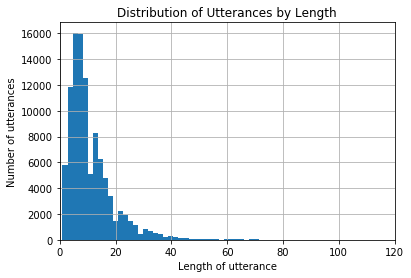

In [10]:
# examining the distribution of the description lengths
df.utter_len.hist(bins = 140)
plt.xlim([0, 120])
plt.title('Distribution of Utterances by Length')
plt.xlabel('Length of utterance')
plt.ylabel('Number of utterances')

# <span id="1"></span>2. Word Frequency
#### [Return Contents](#0)

## Identify The Most Frequent Words

There are a lot of stop words in the list of most frequent words in thedescriptions.  We will need to remove the stop words to get closer to isolating the most relevant keywords in the descriptions.

In [11]:
# getting the word frequency of the original utterance
word_freq = df.dialogue.str.split(expand=True).stack().value_counts()

In [12]:
word_freq[:20]

I       40129
the     35173
you     33198
to      31943
a       26785
and     14910
is      13630
of      12978
in      11860
for     11848
have    11543
it       9107
your     8878
that     8077
are      7998
be       7336
my       6961
do       6959
I’m      6677
like     6548
dtype: int64

Text(0, 0.5, 'Frequency')

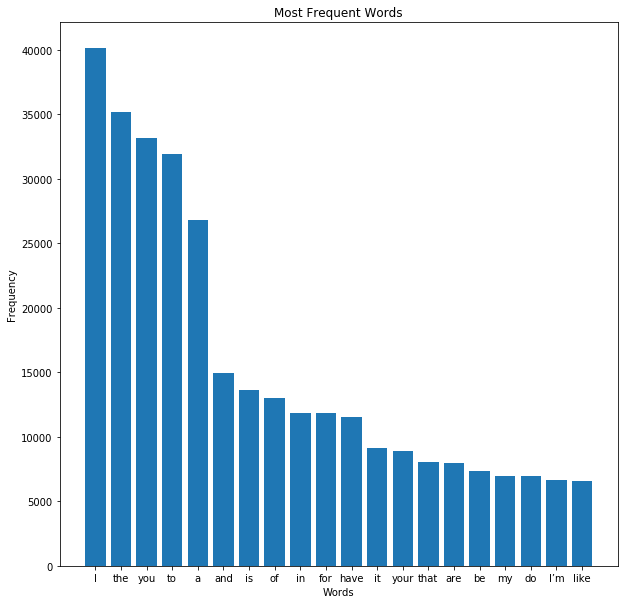

In [14]:
word_freq_top_20 = word_freq[:20]
word_freq_top_20 = dict(word_freq_top_20)
plt.figure(figsize=(10,10))
plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))
plt.title('Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [40]:
# getting the word frequency of the original utterance
word_freq_clean = df.utter_clean.str.split(expand=True).stack().value_counts()

In [41]:
word_freq_clean[:20]

like      7121
yes       6238
well      5157
im        4775
think     4672
good      4550
know      4349
get       4265
would     4196
go        3949
one       3700
dont      3675
see       3674
right     3620
really    3516
want      3302
please    3266
time      3248
oh        3065
thats     2953
dtype: int64

In [48]:
stop_words=set(stopwords.words("english"))
print(stop_words)

[{'mightn', 'those', 'about', "hasn't", 'these', 'i', 'her', 'themselves', 'myself', 'yourself', 'can', 'herself', 'down', 'because', 'ain', "she's", 'he', 'his', 'and', 'why', 'wouldn', 'on', 'below', 'yourselves', 'itself', 'same', 'all', 'few', 'having', 'she', 'am', 'will', 'does', "you'll", 'did', 'which', 'couldn', "you've", 'own', 'you', 'yours', 'its', 'off', 'y', 'at', 'from', 'this', 's', "mustn't", 'some', 'just', 'haven', 'as', 'such', 'now', "haven't", 'not', 'of', 'doesn', 'isn', 'their', 'both', "didn't", 'that', 'above', 'other', 'needn', 'further', 'no', "couldn't", 'during', 'me', 'doing', 'theirs', "mightn't", 'shan', 'after', "doesn't", 'wasn', 'shouldn', "shan't", 'm', 'aren', 'where', 've', 'nor', 'being', 'but', 'are', 'for', 'my', 'by', 'through', "needn't", 'is', 'when', "you'd", 'more', 're', 'a', "should've", 'while', 'there', 'do', 'over', 'him', 'in', 'd', 'here', "weren't", 'any', 'your', 'don', 'was', 'them', 'out', 'again', 'weren', 'than', 'be', 'very',

## Compare Original with Cleaned

After comparing the original utterance with the cleaned version, we may want to be more selective with our stop words than using the standard stopwords included in NLTK.  Some of the utterances will not retain the emotional meaning if we are too hasty.

For example, 

In [46]:
df.head(10)

,dialogue,topic,emotion,type,utter_clean
0,The kitchen stinks .,1,2,3,kitchen stinks
1,I'll throw out the garbage .,1,0,4,ill throw garbage
2,"So Dick , how about getting some coffee for to...",1,4,3,dick getting coffee tonight
3,Coffee ? I don ’ t honestly like that kind of...,1,2,4,coffee honestly like kind stuff
4,"Come on , you can at least try a little , bes...",1,0,3,come least try little besides cigarette
5,What ’ s wrong with that ? Cigarette is the t...,1,1,1,wrong cigarette thing go crazy
6,"Not for me , Dick .",1,0,1,dick
7,Are things still going badly with your housegu...,1,0,2,things still going badly houseguest
8,Getting worse . Now he ’ s eating me out of h...,1,1,1,getting worse eating house home tried talking ...
9,"Leo , I really think you ’ re beating around ...",1,0,3,leo really think beating around bush guy know ...


## Remove Stop Words and Compare Descriptions

After removing stop words, the descriptions are closer to containing only the key words that are most relevant for each movie.

In [376]:
# first of all, let us remove some useless words to see how our documents change
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

In [377]:
df['desc_cleaned'] = df.desc.apply(lambda x:x.lower())
df['without_stopwords'] = df['desc_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

,movieId,imdbId,tmdbId,desc,desc_leng,desc_cleaned,without_stopwords
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ...",50,"led by woody, andy's toys live happily in his ...","led woody, andy's toys live happily room andy'..."
1,2,113497,8844,When siblings Judy and Peter discover an encha...,67,when siblings judy and peter discover an encha...,siblings judy peter discover enchanted board g...
2,3,113228,15602,A family wedding reignites the ancient feud be...,56,a family wedding reignites the ancient feud be...,family wedding reignites ancient feud next-doo...
3,4,114885,31357,"Cheated on, mistreated and stepped on, the wom...",45,"cheated on, mistreated and stepped on, the wom...","cheated on, mistreated stepped on, women holdi..."
4,5,113041,11862,Just when George Banks has recovered from his ...,59,just when george banks has recovered from his ...,"george banks recovered daughter's wedding, rec..."


In [378]:
# comparing description with stopwords and description without stopwords
print(df.without_stopwords[0])
print('------------------------')
print(df.desc[0])

led woody, andy's toys live happily room andy's birthday brings buzz lightyear onto scene. afraid losing place andy's heart, woody plots buzz. circumstances separate buzz woody owner, duo eventually learns put aside differences.
------------------------
Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


# Extract Genre Names and Include in the Description

After testing the model based on the cleaned descriptions, we decided to improve the model's performance by extracting the genres from each movie and including those genre names in the movie description.  This did improve the results slightly.

In [380]:
df = pd.merge(df, lens_deets, on='movieId')

In [381]:
df.head()

,movieId,imdbId,tmdbId,desc,desc_leng,desc_cleaned,without_stopwords,title,genres
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ...",50,led woody andys toys live happily room andys b...,"led woody, andy's toys live happily room andy'...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,113497,8844,When siblings Judy and Peter discover an encha...,67,siblings judy peter discover enchanted board g...,siblings judy peter discover enchanted board g...,Jumanji (1995),Adventure|Children|Fantasy
2,3,113228,15602,A family wedding reignites the ancient feud be...,56,family wedding reignites ancient feud nextdoor...,family wedding reignites ancient feud next-doo...,Grumpier Old Men (1995),Comedy|Romance
3,4,114885,31357,"Cheated on, mistreated and stepped on, the wom...",45,cheated mistreated stepped women holding breat...,"cheated on, mistreated stepped on, women holdi...",Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,113041,11862,Just when George Banks has recovered from his ...,59,george banks recovered daughters wedding recei...,"george banks recovered daughter's wedding, rec...",Father of the Bride Part II (1995),Comedy


In [382]:
df['genres'] = df['genres'].apply(clean_text)

In [383]:
df['desc_cleaned'] = df['desc_cleaned'] + " | " + df['genres']

In [384]:
# compare the cleaned version of description
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences | adventure animation children comedy fantasy'

In [385]:
df['desc_cleaned'] = df['desc_cleaned'].apply(clean_text)

In [386]:
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences adventure animation children comedy fantasy'

<BarContainer object of 20 artists>

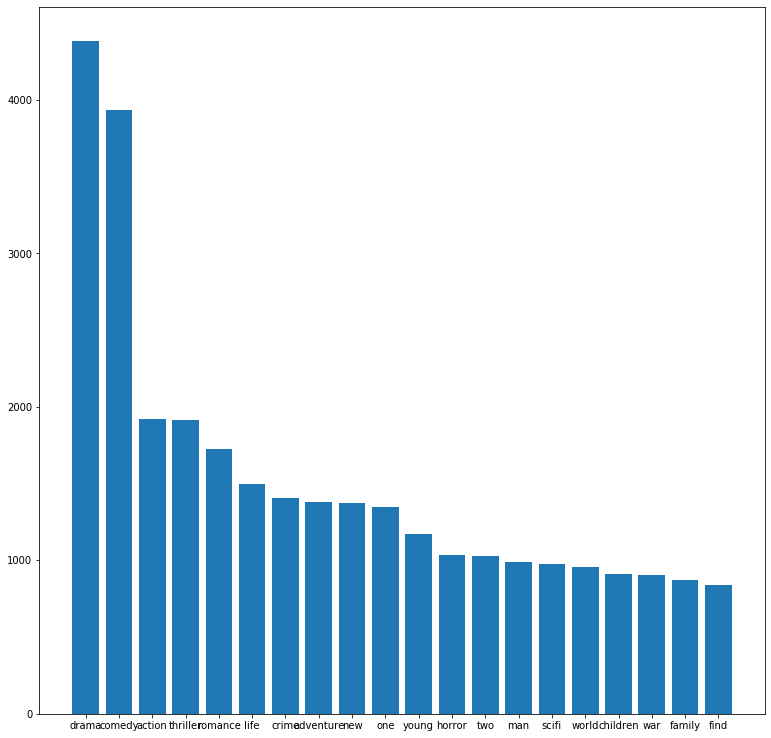

In [387]:
word_freq_clean = df.desc_cleaned.str.split(expand=True).stack().value_counts()
word_freq_clean[:20]
plt.figure(figsize=(13,13))
plt.bar(range(len(word_freq_clean[:20])), dict(word_freq_clean[:20]).values(), tick_label=list(dict(word_freq_clean[:20]).keys()))

# <span id="3"></span>3. Building Recommendation Engine
#### [Return Contents](#0)

In [388]:
df.set_index('title', inplace = True)

In [400]:
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences adventure animation children comedy fantasy'

We calculated the cosine similarity between descriptions by using the TF-IDF Vectorizer.

In [389]:
# calculate cosine similarity between documents - we use tfidf
from sklearn.metrics.pairwise import cosine_similarity
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['desc_cleaned'])
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_similarity(tfidf_matrix, tfidf_matrix))

[[1.00000000e+00 8.39456921e-03 4.75486529e-04 ... 3.98869606e-03
  0.00000000e+00 6.80819529e-03]
 [8.39456921e-03 1.00000000e+00 5.52109710e-03 ... 4.94571179e-03
  0.00000000e+00 1.53948610e-03]
 [4.75486529e-04 5.52109710e-03 1.00000000e+00 ... 2.91077410e-03
  3.34296242e-03 0.00000000e+00]
 ...
 [3.98869606e-03 4.94571179e-03 2.91077410e-03 ... 1.00000000e+00
  0.00000000e+00 5.62537299e-03]
 [0.00000000e+00 0.00000000e+00 3.34296242e-03 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [6.80819529e-03 1.53948610e-03 0.00000000e+00 ... 5.62537299e-03
  0.00000000e+00 1.00000000e+00]]


We saved the cosine similarity matrix for use in other hybrid systems.

In [401]:
import pickle
filename = 'cosine_sim_matrix.pickle'
pickle.dump(similarity_matrix, open(filename, 'wb'))

In [390]:
indices = pd.Series(df.index)

In [391]:
def recommendations(name, similarity_matrix = similarity_matrix):
    
    recommended_movies = []
    
    # getting the index of the movie that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similarity_matrix[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    #Cross reference top n indexes with sleeping giants (and/or giants)
    
    # populating the list with the names of the top 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df.index)[i])
        
    return recommended_movies

In [392]:
# get the list of optional names 
df.index

Index(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)',
       'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)',
       'Sudden Death (1995)', 'GoldenEye (1995)',
       ...
       'Gintama (2017)', 'Gintama: The Movie (2010)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'Silver Spoon (2014)', 'Love Live! The School Idol Movie (2015)',
       'Jon Stewart Has Left the Building (2015)',
       'Black Butler: Book of the Atlantic (2017)',
       'No Game No Life: Zero (2017)', 'Flint (2017)',
       'Bungo Stray Dogs: Dead Apple (2018)'],
      dtype='object', name='title', length=9584)

## Model Testing

Input your favorite movie from the list of almost 10,000 films and get a list of the 10 most similar movies based on their descriptions.

In [397]:
recomendations = input("what types of movies would you like me to recommend for ya?")
recommendations(recomendations)

what types of movies would you like me to recommend for ya?Toy Story (1995)


['Toy Story 2 (1999)',
 'Toy Story 3 (2010)',
 "Child's Play 2 (1990)",
 'Wild, The (2006)',
 'Turbo (2013)',
 'Monsters, Inc. (2001)',
 'The Good Dinosaur (2015)',
 'Malice (1993)',
 'Rebel Without a Cause (1955)',
 'Condorman (1981)']

We can improve this system by including conditional statements in the recommendation function to filter out inapproproate or unrelated recommendations based on their genre, release year, and suitability rating.